## Imports

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))
sys.path.insert(0, os.path.abspath('../algorithms'))
sys.path.insert(0, os.path.abspath('../scoring'))

from algorithms import nearestneighbor
from nearestneighbor import KnnClassifier

from algorithms import decisiontree
from decisiontree import TreeClassifier
from decisiontree import RandomForestClassifier

from algorithms import supportvector
from supportvector import SVC, SVC_multi

from sklearn.preprocessing import StandardScaler
from scores import cross_validation_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from graphing import scoreGraph

# 1) Data-sets

## Reading in the data

The data pulled in here from the csv files comprise a test set and a training set of corrisponding color histogram information. The test set contains 25 unique values for different mushrooms for each of the six species tested. The training set contains 75 samples for each species however, sampling with replacement was carried out due to lack of unique data, to balance the data set, meaning duplicates are in the training set, none of this image data is in the test-set.

### Labels

Binary (0,1) 0 for edible, 1 for poisonous
- y_train_bin
- y_test_bin

Multi Class (0, 1, 2, 3, 4, 5, 6) each corrisponding to a species of mushroom
- y_train
- y_test

### Samples

The 512 features scaled by standard scaler
- X_train_sc
- X_test_sc

8 best featues seleted by chi$^2$ (Used for decision-tree and random forest as experiments where all features were used were too computationally expensive for realistic testing)
- X_train_best
- X_test_best

In [2]:
X_train = np.genfromtxt('../mushroom_images/mushroom_image_train_color_data.csv', delimiter=",")
y_train_bin = np.genfromtxt('../mushroom_images/mushroom_image_train_color_target.csv', delimiter=",")
X_test = np.genfromtxt('../mushroom_images/mushroom_image_test_color_data.csv', delimiter=",")
y_test_bin = np.genfromtxt('../mushroom_images/mushroom_image_test_color_target.csv', delimiter=",")
mushroom_edibility = [0,1,0,0,1,1] #The index of the element corrisponds to the species label 
                                   #number and 0 means edible, 1 means poisonous
    
num_runs = 20 #How many times the scores are going to be gained
    
#Turns multi-class labels to zero and ones
for i in np.arange(X_train.shape[0]):
    y_train_bin[i] = mushroom_edibility[int(y_train_bin[i])]
    
for i in np.arange(X_test.shape[0]):
    y_test_bin[i] = mushroom_edibility[int(y_test_bin[i])]


In [3]:
y_train = np.genfromtxt('../mushroom_images/mushroom_image_train_color_target.csv', delimiter=",")
y_test = np.genfromtxt('../mushroom_images/mushroom_image_test_color_target.csv', delimiter=",")

In [4]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [5]:
selector = SelectKBest(chi2,k=8)
selector.fit(X_train, y_train)
X_train_best = selector.transform(X_train)
X_test_best = selector.transform(X_test)

## Creating 20 pairs of random train and test combinations, 400 samples in train, 100 in tests

In [6]:
random_train_indices = []
random_test_indices = []
X_train_scs = []
X_train_bests = []
y_train_bins = []
y_trains = []

X_test_scs = []
X_test_bests = []
y_test_bins = []
y_tests = []

train_sample_size = 400
test_sample_size = 100

for i in np.arange(num_runs):
    np.random.seed(i)
    random_train_indices.append(np.random.choice(X_train_sc.shape[0], size=train_sample_size))
    X_train_scs.append(X_train_sc[random_train_indices[i],:])
    X_train_bests.append(X_train_best[random_train_indices[i],:])
    y_train_bins.append(y_train_bin[random_train_indices[i]])
    y_trains.append(y_train[random_train_indices[i]])
    
    
for i in np.arange(num_runs):
    np.random.seed(i)
    random_test_indices.append(np.random.choice(X_test_sc.shape[0], size=test_sample_size))
    X_test_scs.append(X_test_sc[random_test_indices[i],:])
    X_test_bests.append(X_test_best[random_test_indices[i],:])
    y_test_bins.append(y_test_bin[random_test_indices[i]])
    y_tests.append(y_test[random_test_indices[i]])

[array([[ 0.51198944, -0.28991808, -0.01215457, ..., -0.08317114,
        -0.08479885, -0.06672166],
       [ 0.61580129, -0.28991808, -0.3467109 , ..., -0.08317114,
        -0.08479885, -0.06672166],
       [ 0.48223071, -0.28991808, -0.3467109 , ..., -0.08317114,
        -0.08479885, -0.06672166],
       ...,
       [ 0.6568107 , -0.28991808, -0.31011052, ..., -0.08317114,
        -0.08479885, -0.06672166],
       [ 0.68443859, -0.28991808, -0.3467109 , ..., -0.08317114,
        -0.08479885, -0.06672166],
       [-0.18191972, -0.28991808,  0.13780431, ..., -0.08317114,
        -0.08479885, -0.06672166]]), array([[ 0.6828878 , -0.28991808, -0.3467109 , ..., -0.08317114,
        -0.08479885, -0.06672166],
       [ 0.39778581, -0.28991808, -0.30221307, ..., -0.08317114,
        -0.08479885, -0.06672166],
       [ 0.64248827, -0.28991808, -0.30910078, ..., -0.08317114,
        -0.08479885, -0.06672166],
       ...,
       [-0.26491671, -0.13637616, -0.15802913, ..., -0.08317114,
        

The data pulled in here consists of the labels for the multi-class species problem

X_train and X_test scaled by standard scaler using StandardScaler

Selects top features that have the biggest effect on the X_train's labels and constructs a X_train and X_test that only consist of these features.

# 2) Tuning Parameters

## $k$ nearest-neighbours

As this algorithm only has one parameter it is possible with my python implementation, to exhaustively test the parameters using my implemetation of cross validation, which carries out rescaling with every fold, to avoid data snooping.

### Selecting $k$
Red line indicates best $k$

Optimisation graph for k with binary labels


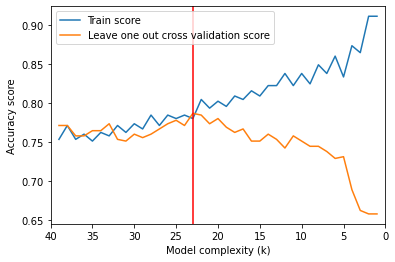

Best k is 23 as it is the top of the generalisation curve


In [7]:
scores = list()
crossvalscores = list()
top_k = 40
scaler = StandardScaler()


for k in range(1,top_k, 1):
    knn = KnnClassifier(k)
    knn.fit(X_train, y_train_bin)
    knnScore = knn.score(X_train, y_train_bin)
    scores.append(knnScore)
    cvs = cross_validation_score()
    crossvalscores.append(np.mean(cvs.score(knn, X_train, y_train_bin, cv=75,scaler=scaler)))
plt.plot(np.arange(1,top_k, 1), scores)
plt.plot(np.arange(1,top_k, 1), crossvalscores)
plt.xlim(top_k , 0)
plt.xlabel("Model complexity (k)")
plt.ylabel("Accuracy score")
plt.legend(["Train score", "Leave one out cross validation score"])
plt.axvline(23, 0, 1, label='k=20', c='red')
print("Optimisation graph for k with binary labels" )
plt.show()
print("Best k is 23 as it is the top of the generalisation curve")

Optimisation graph for k with multi-class labels


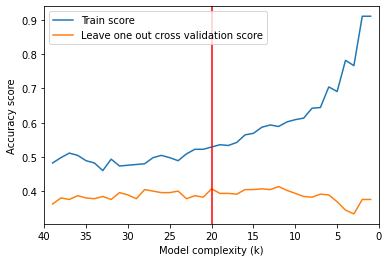

Best k is 20 as it is the top of the generalisation curve


In [8]:
scores = list()
crossvalscores = list()
top_k = 40
scaler = StandardScaler()

for k in range(1,top_k, 1):
    knn = KnnClassifier(k)
    knn.fit(X_train, y_train)
    knnScore = knn.score(X_train, y_train)
    scores.append(knnScore)
    cvs = cross_validation_score()
    crossvalscores.append(np.mean(cvs.score(knn, X_train, y_train, cv=75,scaler=scaler)))
plt.plot(np.arange(1,top_k, 1), scores)
plt.plot(np.arange(1,top_k, 1), crossvalscores)
plt.xlim(top_k , 0)
plt.xlabel("Model complexity (k)")
plt.ylabel("Accuracy score")
plt.legend(["Train score", "Leave one out cross validation score"])
plt.axvline(20, 0, 1, label='k=20', c='red')
print("Optimisation graph for k with multi-class labels" )
plt.show()
print("Best k is 20 as it is the top of the generalisation curve")

## Decision tree

It was not computationally viable to carry out grid search with multiple parameters with my implementation as my implementaion of decision tree is written in python and takes a long time to run. Therefore this project will use sci-kit learn's implementation of decision_tree only to tune parameters, the end tests will use the projects' implementation. Pipeline and GridSearch will also be used from the sklearn library.


In [9]:
from sklearn import tree as decision_tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [10]:
tree = decision_tree.DecisionTreeClassifier()
parameters = dict(max_depth=np.arange(1,75).tolist(), min_samples_leaf=np.arange(1,75).tolist())
grid_search = GridSearchCV(estimator=tree, param_grid=parameters)
grid_search.fit(X_train_best, y_train_bin)
print("Best parameters for binary labels")
print('Best tree_height:', grid_search.best_estimator_.get_params()['max_depth'])
print('Best length_stopping_criterion:', grid_search.best_estimator_.get_params()['min_samples_leaf'])

Best parameters for binary labels
Best tree_height: 2
Best length_stopping_criterion: 53


In [11]:
tree = decision_tree.DecisionTreeClassifier()
parameters = dict(max_depth=np.arange(1,75).tolist(), min_samples_leaf=np.arange(1,75).tolist())
grid_search = GridSearchCV(estimator=tree, param_grid=parameters)
grid_search.fit(X_train_best, y_train)
print("Best parameters for multi class labels")
print('Best tree_height:', grid_search.best_estimator_.get_params()['max_depth'])
print('Best length_stopping_criterion:', grid_search.best_estimator_.get_params()['min_samples_leaf'])

Best parameters for multi class labels
Best tree_height: 4
Best length_stopping_criterion: 36


## Random forest
It was not computationally viable to carry out grid search with multiple parameters with my implementation as my implementaion of decision tree is written in python and takes a long time to run. Therefore this project will use sci-kit learn's implementation of random_forest only to tune parameters, the end tests will use the projects' implementation. GridSearch will also be used from the sklearn library.

In [12]:
from sklearn.ensemble import RandomForestClassifier as RFC

In [13]:
rfc = RFC(random_state=1)
step = 5
parameters = dict(min_samples_leaf=np.arange(1,75,step).tolist(), max_samples=np.arange(1,75,step,).tolist()
            ,n_estimators=[100])
grid_search = GridSearchCV(estimator=rfc, param_grid=parameters, cv=10)
grid_search.fit(X_train_best, y_train_bin)
print("Best parameters for binary labels")
print('Best length_stopping_criterion:', grid_search.best_estimator_.get_params()['min_samples_leaf'])
print('Best ratio:', grid_search.best_estimator_.get_params()['max_samples']/X_train.shape[0])

Best parameters for binary labels
Best length_stopping_criterion: 11
Best ratio: 0.10222222222222223


In [14]:
rfc = RFC(random_state=1)
step = 5
parameters = dict(min_samples_leaf=np.arange(1,75,step).tolist(), max_samples=np.arange(1,75,step,).tolist()
            ,n_estimators=[100])
grid_search = GridSearchCV(estimator=rfc, param_grid=parameters, cv=10)
grid_search.fit(X_train_best, y_train)
print("Best parameters for binary labels")
print('Best length_stopping_criterion:', grid_search.best_estimator_.get_params()['min_samples_leaf'])
print('Best ratio:', grid_search.best_estimator_.get_params()['max_samples']/X_train.shape[0])

Best parameters for binary labels
Best length_stopping_criterion: 6
Best ratio: 0.08


## Support Vector Classifier
My implementation uses different parameters to the sklearn implementation, so I chose number of iterations to be high (5000) and learn rate and lambda for my implementation to be low , both being 0.01. This gives the best model as the line moves slowly but after enough iterations will get the right hyperplane

# 3) Getting accuracy scores

This section only uses this projects implementation of the algorithms

# 3.1) Binary mushroom edible or mushroom poisonous problem

## $k$ nearest-neighbours

In [15]:
from scores import confusion_matrix
final_accuracy = {}
final_precision = {}
final_specificity = {}
final_sensitivity = {}



accuracy = []
precision = []
sensitivity = []
specificity = []
for i in np.arange(len(X_train_scs)):
    print('*', end="")
    X_train_sc = X_train_scs[i]
    y_train_bin = y_train_bins[i]
    X_test_sc = X_test_scs[i]
    y_test_bin = y_test_bins[i]
    knn = KnnClassifier(23)
    knn.fit(X_train_sc, y_train_bin)
    cm = confusion_matrix()
    cm.generate(knn.predict(X_test_sc), y_test_bin)
    accuracy.append(cm.accuracy())
    precision.append(cm.precision())
    sensitivity.append(cm.sensitivity())
    specificity.append(cm.specificity())

name = 'knn'
final_accuracy[name] = round(np.mean(accuracy), 3)
final_precision[name] = round(np.mean(precision), 3)
final_specificity[name] = round(np.mean(sensitivity), 3)
final_sensitivity[name] = round(np.mean(specificity), 3)

********************

## Decision tree

In [16]:

accuracy = []
precision = []
sensitivity = []
specificity = []
for i in np.arange(len(X_train_scs)):
    print('*', end="")
    X_train_best = X_train_bests[i]
    y_train_bin = y_train_bins[i]
    X_test_best = X_test_bests[i]
    y_test_bin = y_test_bins[i]
    classifier = TreeClassifier()
    classifier.fit(X_train_best, y_train_bin, tree_height=2, length_stopping_criterion=53)
    cm = confusion_matrix()
    cm.generate(classifier.predict(X_test_best), y_test_bin)
    accuracy.append(cm.accuracy())
    precision.append(cm.precision())
    sensitivity.append(cm.sensitivity())
    specificity.append(cm.specificity())
    
name = 'tree'
final_accuracy[name] = round(np.mean(accuracy), 3)
final_precision[name] = round(np.mean(precision), 3)
final_specificity[name] = round(np.mean(sensitivity), 3)
final_sensitivity[name] = round(np.mean(specificity), 3)

********************

## Random forest

In [17]:
accuracy = []
precision = []
sensitivity = []
specificity = []

for i in np.arange(len(X_train_scs)):

    print('*', end="")
    X_train_best = X_train_bests[i]
    y_train_bin = y_train_bins[i]
    X_test_best = X_test_bests[i]
    y_test_bin = y_test_bins[i]
    rfc = RandomForestClassifier()
    rfc.fit(X_train_best, y_train_bin,tree_height=10000, length_stopping_criterion=11, num_trees=100, ratio=0.08)
    cm = confusion_matrix()
    cm.generate(rfc.predict(X_test_best), y_test_bin)
    accuracy.append(cm.accuracy())
    precision.append(cm.precision())
    sensitivity.append(cm.sensitivity())
    specificity.append(cm.specificity())
    
name = 'rfc'
final_accuracy[name] = round(np.mean(accuracy), 3)
final_precision[name] = round(np.mean(precision), 3)
final_specificity[name] = round(np.mean(sensitivity), 3)
final_sensitivity[name] = round(np.mean(specificity), 3)

********************

## Support vector classifier 

In [18]:
accuracy = []
precision = []
sensitivity = []
specificity = []
for i in np.arange(len(X_train_scs)):
    print('*', end="")
    X_train_sc = X_train_scs[i]
    y_train_bin = y_train_bins[i]
    X_test_sc = X_test_scs[i]
    y_test_bin = y_test_bins[i]
    svm = SVC(learning_rate=0.01, lambda_param=0.01, n_iters=2000)    
    svm.fit(X_train_sc, (y_train_bin * 2) - 1)
    cm = confusion_matrix()
    cm.generate(((svm.predict(X_test_sc)+1)/2), y_test_bin)
    accuracy.append(cm.accuracy())
    precision.append(cm.precision())
    sensitivity.append(cm.sensitivity())
    specificity.append(cm.specificity())
    
name = 'svm'
final_accuracy[name] = round(np.mean(accuracy), 3)
final_precision[name] = round(np.mean(precision), 3)
final_specificity[name] = round(np.mean(sensitivity), 3)
final_sensitivity[name] = round(np.mean(specificity), 3)

********************

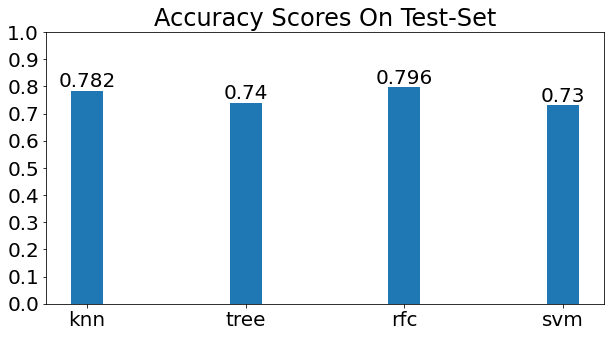

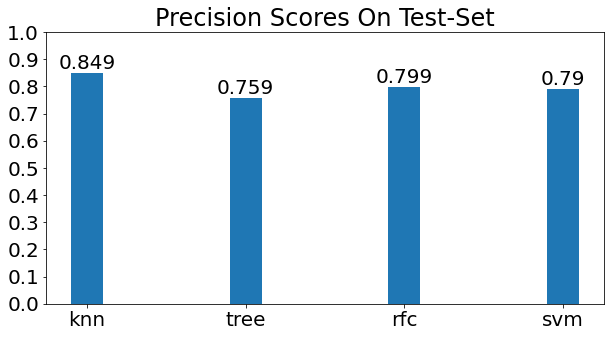

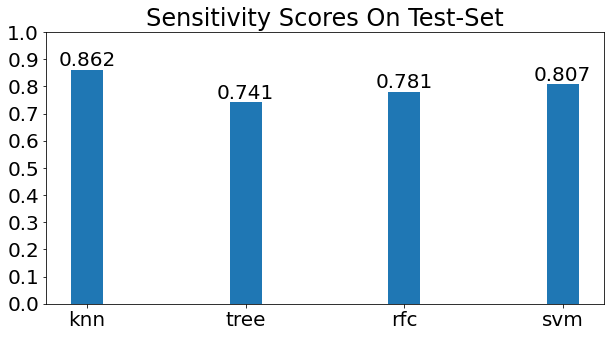

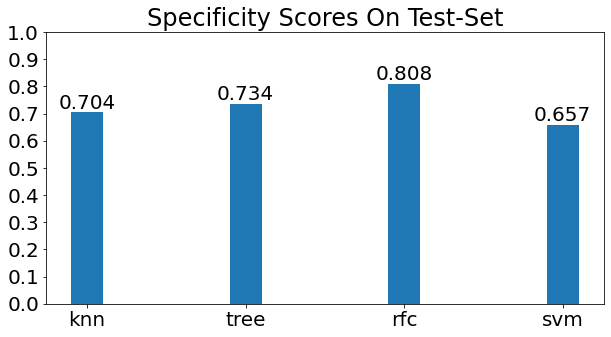

In [19]:
scoreGraph(final_accuracy, title="Accuracy")
scoreGraph(final_precision, title="Precision")
scoreGraph(final_sensitivity, title="Sensitivity")
scoreGraph(final_specificity, title="Specificity")


# 3.2) Multi-class species problem

In [20]:
final_accuracy = {}

## $k$ nearest-neighbours

In [21]:
accuracy = []
for i in np.arange(len(X_train_scs)):
    print('*', end="")
    X_train_sc = X_train_scs[i]
    y_train = y_trains[i]
    X_test_sc = X_test_scs[i]
    y_test = y_tests[i]
    knn = KnnClassifier(20)
    knn.fit(X_train_sc, y_train)
    accuracy.append(knn.score(X_test_sc, y_test))
name = 'knn'
final_accuracy[name] = round(np.mean(accuracy), 3)

********************

## Decision tree

In [22]:
accuracy = []
for i in np.arange(len(X_train_scs)):
    print('*', end="")
    X_train_best = X_train_bests[i]
    y_train = y_trains[i]
    X_test_best = X_test_bests[i]
    y_test = y_tests[i]

    classifier = TreeClassifier(classes=[0,1,2,3,4,5])
    classifier.fit(X_train_best, y_train, tree_height=4, length_stopping_criterion=36)
    accuracy.append(classifier.score(X_test_best, y_test))
name = 'tree'
final_accuracy[name] = round(np.mean(accuracy), 3)

********************

## Random forest

In [23]:
accuracy = []
for i in np.arange(len(X_train_scs)):
    print('*', end="")
    X_train_best = X_train_bests[i]
    y_train = y_trains[i]
    X_test_best = X_test_bests[i]
    y_test = y_tests[i]

    rfc = RandomForestClassifier(classes=[0,1,2,3,4,5])
    rfc.fit(X_train_best, y_train, tree_height=10000, length_stopping_criterion=6, num_trees=100, ratio=0.14666666666666667)
    accuracy.append(rfc.score(X_test_best, y_test))
name = 'rfc'
final_accuracy[name] = round(np.mean(accuracy), 3)

********************

## Support vector classifier 

In [24]:
accuracy = []
for i in np.arange(len(X_train_scs)):
    print('*', end="")
    X_train_sc = X_train_scs[i]
    y_train = y_trains[i]
    X_test_sc = X_test_scs[i]
    y_test = y_tests[i]
    svm = SVC_multi(learning_rate=0.01, lambda_param=0.01, n_iters=2000)    
    svm.fit(X_train_sc, y_train, method='one_v_one')
    accuracy.append(svm.score(X_test_sc, y_test))
name = 'svm\none_v_one'
final_accuracy[name] = round(np.mean(accuracy), 3)

********************

In [25]:
accuracy = []
for i in np.arange(len(X_train_scs)):
    print('*', end="")
    X_train_sc = X_train_scs[i]
    y_train = y_trains[i]
    X_test_sc = X_test_scs[i]
    y_test = y_tests[i]
    svm = SVC_multi(learning_rate=0.01, lambda_param=0.01, n_iters=2000)    
    svm.fit(X_train_sc, y_train, method='one_v_rest')
    accuracy.append(svm.score(X_test_sc, y_test))
name = 'svm\none_v_rest'
final_accuracy[name] = round(np.mean(accuracy), 3)

********************

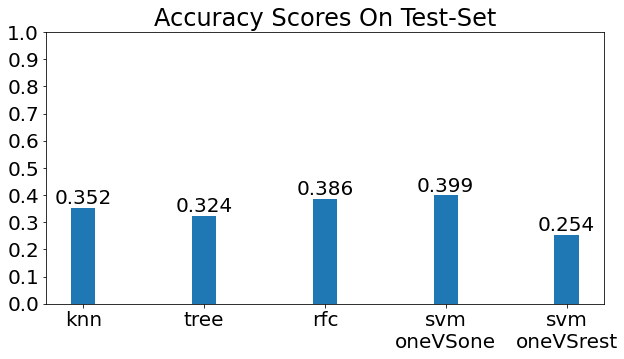

In [26]:
scoreGraph(final_accuracy, title="Accuracy")